## 번역기를 만들어보자

#### 라이브러리 로드 

In [1]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

#### 설정값 관리

In [2]:
totOfSamples = 33000
testOfSamples = 3000
sos_token = '<sos>'
eos_token = '<eos>'
embedding_dim = 128
hidden_units = 128

#### 라이별 전처리 수행 
- 소문자
- space + 구두점 처리

In [89]:
def remove_accent(s):
    # 프랑스어 악센트(accent) 삭제
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [90]:
def preprocess_line(sent):
    sent = sentence.lower().strip()
    # 악센트 삭제 함수 호출
    sent = remove_accent(sent)

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)
    sent = re.sub(r'[" "]+', " ", sent)
    
    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent

#### 전처리 데이터 불러오기

In [91]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("data/fra.txt", "r") as lines:
        for i, line in enumerate(lines):
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line = [w for w in preprocess_line(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_line(tar_line)
            tar_line_in = [w for w in (sos_token + " " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " " + eos_token).split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == totOfSamples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [85]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()

In [97]:
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


In [72]:
pd.DataFrame(sents_en_in).head(5)

,0,1,2,3,4,5,6,7
0,go,.,None,None,None,None,None,None
1,go,.,None,None,None,None,None,None
2,go,.,None,None,None,None,None,None
3,go,.,None,None,None,None,None,None
4,hi,.,None,None,None,None,None,None


#### 토크나이징 

In [93]:

tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer()
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [62]:
pd.DataFrame(encoder_input).head(5)

,0,1,2,3,4,5,6,7
0,28,1,0,0,0,0,0,0
1,28,1,0,0,0,0,0,0
2,28,1,0,0,0,0,0,0
3,28,1,0,0,0,0,0,0
4,761,1,0,0,0,0,0,0


In [61]:
pd.DataFrame(decoder_target).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,75,8,3,0,0,0,0,0,0,0,0,0,0,0,0,0
1,365,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28,512,8,3,0,0,0,0,0,0,0,0,0,0,0,0
3,716,8,3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,750,8,3,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [14]:
max_src_len = encoder_input.shape[1]
max_tar_len = decoder_input.shape[1]
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 8
target 문장의 최대 길이 : 16


In [15]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4673, 프랑스어 단어 집합의 크기 : 7456


In [16]:
encoder_input_train = encoder_input[:-testOfSamples]
decoder_input_train = decoder_input[:-testOfSamples]
decoder_target_train = decoder_target[:-testOfSamples]

encoder_input_test = encoder_input[-testOfSamples:]
decoder_input_test = decoder_input[-testOfSamples:]
decoder_target_test = decoder_target[-testOfSamples:]

In [17]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 16)
훈련 target 레이블의 크기 : (30000, 16)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 16)
테스트 target 레이블의 크기 : (3000, 16)


In [18]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [19]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    598144      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    954368      input_2[0][0]                    
______________________________________________________________________________________________

### Training

In [108]:
model_history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 6s 26ms/step - loss: 0.1373 - acc: 0.9556 - val_loss: 1.2193 - val_acc: 0.8251
Epoch 2/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1339 - acc: 0.9564 - val_loss: 1.2216 - val_acc: 0.8247
Epoch 3/50
235/235 [==============================] - 6s 26ms/step - loss: 0.1305 - acc: 0.9569 - val_loss: 1.2274 - val_acc: 0.8259
Epoch 4/50
235/235 [==============================] - 6s 26ms/step - loss: 0.1268 - acc: 0.9574 - val_loss: 1.2397 - val_acc: 0.8249
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1240 - acc: 0.9577 - val_loss: 1.2420 - val_acc: 0.8246
Epoch 6/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1207 - acc: 0.9584 - val_loss: 1.2481 - val_acc: 0.8266
Epoch 7/50
235/235 [==============================] - 6s 26ms/step - loss: 0.1184 - acc: 0.9588 - val_loss: 1.2612 - val_acc: 0.8267
Epoch 8/50
235/235 [==============================] - 6s 25ms/step - 

###### 참고: https://github.com/bamtu/Aiffel-exploration/blob/main/%5BE-10%5D%20Translation.ipynb

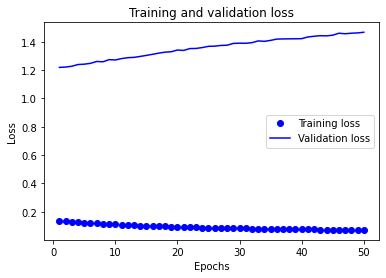

In [112]:
import matplotlib.pyplot as plt
history = model_history.history
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 테스트

In [24]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

In [25]:
# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [94]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

In [26]:
# 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [98]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
            len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [100]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + index_to_src[encoded_word] + ' '
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
            sentence = sentence + index_to_tar[encoded_word] + ' '
    return sentence
     

In [105]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
    print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
    print("번역문장 :",decoded_sentence[1:-5])
    print("-"*50)

입력문장 : go . 
정답문장 : sante a 
번역문장 : on a 
--------------------------------------------------
입력문장 : hello ! 
정답문장 : chaussures a 
번역문장 : chaussures a 
--------------------------------------------------
입력문장 : got it ? 
정답문장 : ce tres plais ? 
번역문장 : ! ce il de ce y ? 
--------------------------------------------------
입력문장 : hang on . 
정답문장 : savoir mal a 
번역문장 : fille . 
--------------------------------------------------
입력문장 : here s . 
정답문장 : sors parait allumes . 
번역문장 : sors parait allumes . 
--------------------------------------------------


In [106]:
for seq_index in [3, 50, 100, 300, 1001]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
    print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
    print("번역문장 :",decoded_sentence[1:-5])
    print("-"*50)

입력문장 : i love a challenge . 
정답문장 : j train d l avant . 
번역문장 : j train ai parti . 
--------------------------------------------------
입력문장 : i met an old woman . 
정답문장 : j le musique moi jouer prete . 
번역문장 : j le content moi ce ils . 
--------------------------------------------------
입력문장 : i never got caught . 
정답문장 : je suis ca tu reste tout veut . 
번역문장 : je etes le reste evacuer . 
--------------------------------------------------
입력문장 : i want to end this . 
정답문장 : je etais presse sur . 
번역문장 : je etais ai virez . 
--------------------------------------------------
입력문장 : it won t last long . 
정답문장 : ! suis uds pas ok . 
번역문장 : ! suis on pas sorti . 
--------------------------------------------------


## 회고


1. 언어, 번역대상언어셋을 로드하여 전처리 과정을 거침/ 전처리 시 구두점을 단어와 분리하거나 삭제
2. keras의 tokenizer fit_on_texts와 word_index를 사용하여 key value로 이루어진 딕셔너리를 만든다
3. texts_to_sequences를 이용 text문장을 숫자 리스트로 변환
4. pad_sequences를 이용하여 리스트 길이 통일 
5. 인코더 설계, 마스킹은 패딩 토큰 숫자 0의 경우 연산제외 설정, 인코더 내부 상태 디코더로 넘겨주기위해 return_state = True 설정
6. LSTM 은닉상태와 셀 상태를 encoder_states에 저장하고 디코더에 전달 -> 컨텍스트 벡터
7. 디코더 인코더 마지막 은닉상태에서 초기 은닉상태 얻음, 디코더도 은닉상태, 셀상태 리턴은 하지만 훈련과정에서는 사용하지 않음
   seq2seq에서 디코더는 각 시점마다 다중 클래스 분류 문제 풀이, 출력층은 소프트맥스와 손실함수는 크로스앤트로피 사용
8. 원핫인코딩 하지 않은 상태 정수 레이블에 대해서 다중 클래스 분류문제 풀경우 categorical_crossentropy가 아닌 sparse_categorical_crossentropy사용
9. 모델은 128배치로 50 에포크 수행
10. 테스트
  10.1 번영하고자 하는 입력문장 인코더로 입력되어 인코더 마지막 시점 은닉상태와 셀 상태 획득
      . 인코더 입,출력으로 사용하는 encoder_inputs와 encoder_states는 훈련과정에서 이미 정의한 것들 재사용 이경우 훈련 단계에 
      encoder_inputs와 encoder_states 사이에 있는 모든 층까지 전부 불러오게 되므로 결과적으로 훈련 단계에서 사용한 인코더를 그대로 재사용
  10.2 인코더 은닉상태와 셀 상태, 그리고 토큰<sos>를 디코더로 보냄
  10.3 디코더가 토큰<eos>가 나올때까지 다음 단어 예측행위 반복 
  10.4 디코더 설계
  10.5 decode_sequence함수 구현
      . 문장이 입력되면 인코더는 마지막 시점까지 전개, 마지막 시점 은닉상태/셀 상태 리턴, 두 개 값 states_value에 저장
      . 디코더 초기 입력 <SOS>준비, target_seq에 저장 while문에서 입력으로 사용 , 현재 시점 예측벡터가 output_tokens, 현재시점의 은닉상태,셀상태가 C-> 예측 벡터로 부터 현재 시점 예측 단어 target_seq얻고, h와c states_value에 저장 이를 <eos> or 번역문장이 50보다 작은 경우 반복
    각 시점마다 번역된 단어 decoded_sentence에 누적 저장 후 최종 번역 시퀀스로 리턴 함
 11. 각 흐름을 따라가면서 데이터/상태/변환등의 과정을 확인하여 전체 프로세스를 이해할 수 있었고 세부적인 부분도 확인이 가능하였음   
     